In [2]:
# Copyright 2022 Huawei Technologies Co., Ltd.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# author: Benjamin Lozes

In [3]:
filename = '/home/belozes/HyperDAG_DB/tools/HyperDAG_generator/LLtSolver2.txt'

In [17]:
from collections import defaultdict 
import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt
import hypernetx as hnx
import hnxwidget
from typing import Set, Dict

In [12]:
def read_hyperdag(filename: str) -> hnx.Hypergraph:
    hyperedges: Dict[int, Set[int]] = {}
    with open(filename, 'r') as file:
        # Find the number of hyperedges, nodes and pins ( 1st uncommented line )
        n_hyperedges: int = 0
        n_nodes: int = 0 
        n_pins: int = 0
        for line in file:
            if line.startswith('%'):
                continue
            n_hyperedges = int(line.split()[0])
            n_nodes = int(line.split()[1])
            n_pins = int(line.split()[2])
            break
        
        # Read the hyperedges
        for line in file:
            if line.startswith('%'):
                continue
            hyperedge_id = int(line.split()[0])
            hyperedges[hyperedge_id] = set()
            if len(hyperedges) == n_hyperedges:
                break
        
        # Skip the read of the nodes
        nodes_counter: int = 0
        for line in file:
            if line.startswith('%'):
                continue
            nodes_counter += 1
            if nodes_counter == n_nodes:
                break
        
        # Read the pins
        for line in file:
            if line.startswith('%'):
                continue
            hyperedge_id = int(line.split()[0])
            node_id = int(line.split()[1])
            hyperedges[hyperedge_id].add(node_id)
    
    return hnx.Hypergraph(hyperedges)

In [18]:
hdag = read_hyperdag(filename)
print(hdag)

None, <class 'hypernetx.classes.hypergraph.Hypergraph'>


---
# Show DAG

In [ ]:
self = hnxwidget.HypernetxWidget(hdag)

HypernetxWidget(component='HypernetxWidget', props={'nodes': [{'uid': '46'}, {'uid': '62'}, {'uid': '33'}, {'u…

In [ ]:
self.state

In [ ]:
pos = nx.nx_agraph.graphviz_layout(G, prog='dot') # this will also be used for hypergraphs later

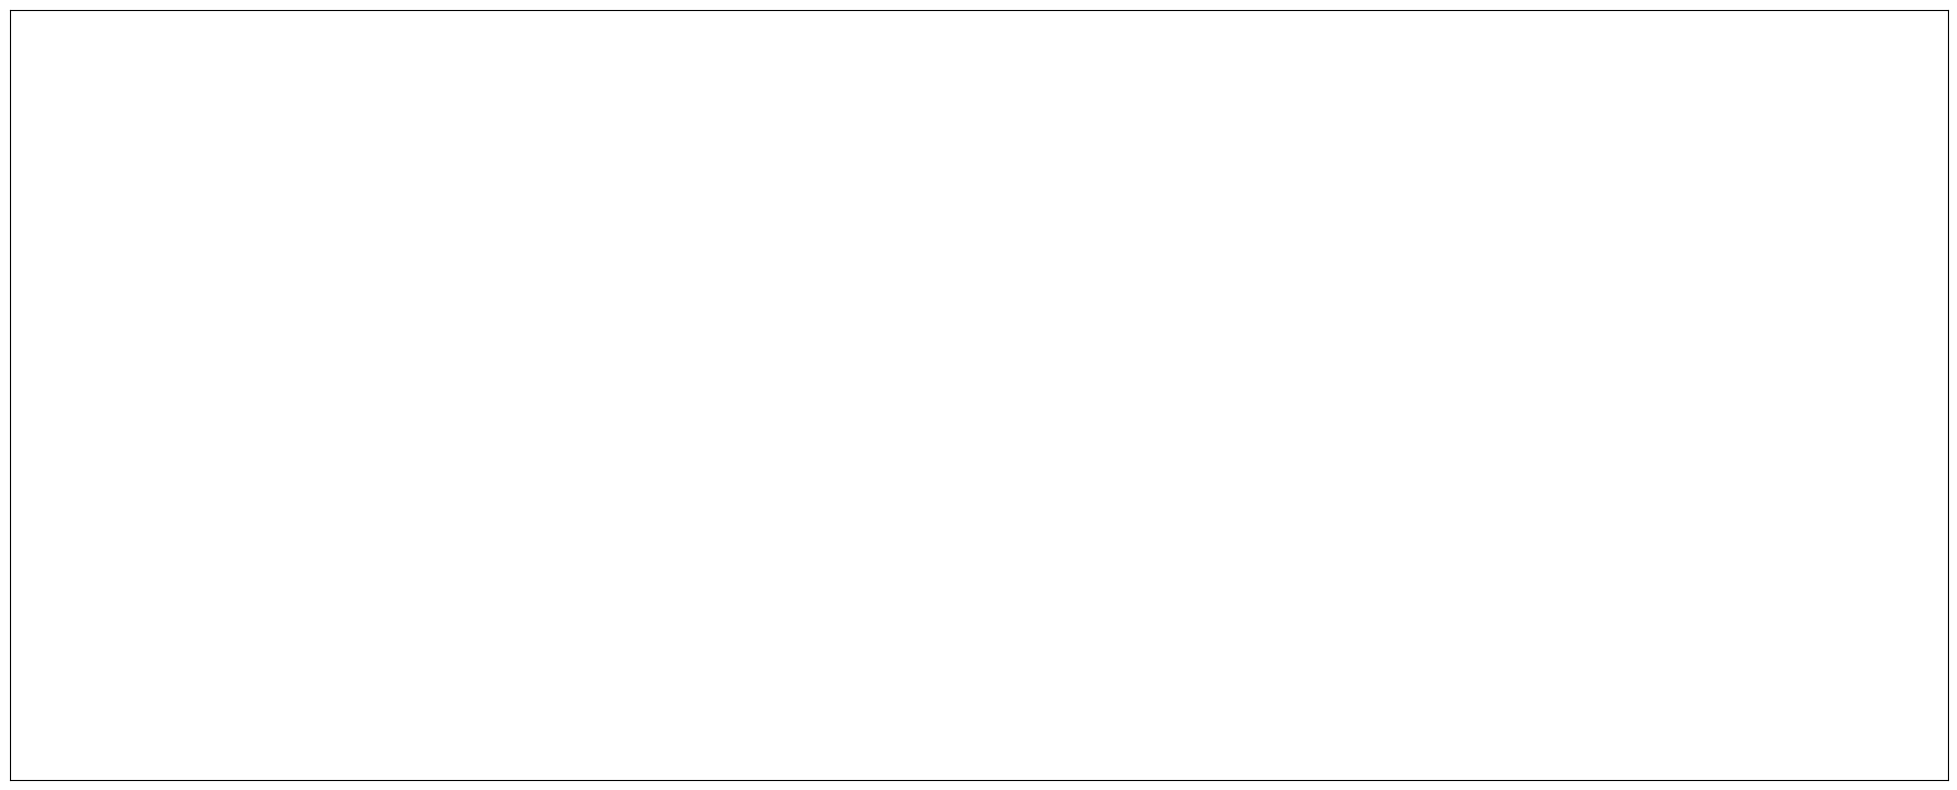

In [ ]:
fig = plt.figure()
fig.set_size_inches(25, 10)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=750)
nx.draw_networkx_edges(G, pos, edge_color='blue', arrowsize=30)
nx.draw_networkx_labels(G, pos, font_size=20)
plt.savefig("dag.jpg")
plt.show()

---
# Show HyperDAG (source nodes colored)

In [ ]:
nets = {int(index): tuple(net) for index, net in hdag.items()}
H = hnx.Hypergraph(nets)
sources = {next(iter(net.elements.items()))[0]: net.uid  for net in H.edges()}
# write new attribute source_of to nodes
for v in H.nodes():
    v.source_of = sources.get(v.uid)

In [ ]:
settings = {
    'width': 25,
    'height': 10,
    'xstretch': 1,
    'ystretch': 4,
    'net_padding': 0.2,
    'source_size': 0.8,
    'sink_size': 0.5,
}    

In [ ]:
cmap = plt.cm.viridis
colors = cmap(plt.Normalize(0, len(hdag))(range(len(hdag))))

fig = plt.figure()
fig.set_size_inches(settings['width'], settings['height'])

hnx.drawing.draw(H,
                 pos={key: (settings['xstretch']*x, settings['ystretch']*y) for key, (x,y) in pos.items()}, # use pos from digraph (cannot use graphviz.dot on hypergraphs)
                 edges_kwargs={
                     'edgecolors': colors,
                     'dr': settings['net_padding']
                  },
                 nodes_kwargs={
                    'facecolors': [colors[v.source_of] if v.source_of != None else 'gray' for v in H.nodes()]
                  },
                 node_radius={
                     v.uid: settings['source_size'] if v.uid in sources else settings['sink_size'] for v in H.nodes()
                  }
                )
fig.savefig("hyperdag.jpg")
plt.show()